# **Binary-Class Text Classification For Fake News**

**Import libraries**


In [91]:
# basic lib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np

# nlp preprocessing using tensorflow lib 
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import string 
punctation = string.punctuation 


**Defining our datasets**

In [92]:
true = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

**EDA for true news**

In [93]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [94]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [95]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [135]:
print("Number of rows before remove duplicates : {}".format(true.shape[0]))

Number of rows before remove duplicates : 21211


In [108]:
print("Duplicated rows before remove them : ")
true[true.duplicated(keep=False)].sort_values(by="text").head(8)

Duplicated rows before remove them : 


,title,text,subject,date
11816,Russia detains Norwegian citizen over suspecte...,(Corrects a Dec. 19 story to make clear in gr...,worldnews,"December 19, 2017"
11720,Russia detains Norwegian citizen over suspecte...,(Corrects a Dec. 19 story to make clear in gr...,worldnews,"December 19, 2017"
11777,UK's May to visit China around Jan. 31: Sky News,(Reuters) - British Prime Minister Theresa May...,worldnews,"December 20, 2017"
11681,UK's May to visit China around Jan. 31: Sky News,(Reuters) - British Prime Minister Theresa May...,worldnews,"December 20, 2017"
11800,"Germany's conservatives, SPD start talks Jan. ...",(Reuters) - German Chancellor Angela Merkel s ...,worldnews,"December 20, 2017"
11704,"Germany's conservatives, SPD start talks Jan. ...",(Reuters) - German Chancellor Angela Merkel s ...,worldnews,"December 20, 2017"
4033,Highlights: The Trump presidency on April 28 a...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"April 28, 2017"
3998,Highlights: The Trump presidency on April 28 a...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"April 28, 2017"


In [109]:
print("Number of duplicates in data : {}".format(len(true[true.duplicated()]))) 

Number of duplicates in data : 206


In [110]:
#remove duplicated rows
true.drop_duplicates(inplace=True)

In [112]:
print("Number of duplicates in data after using drop_duplicates: {}".format(len(true[true.duplicated()]))) 

Number of duplicates in data after using drop_duplicates: 0


In [113]:
#data classifies into two classes "politicsNews" and "worldnews"
true.subject.value_counts()

politicsNews    11220
worldnews        9991
Name: subject, dtype: int64

Text(0.5, 0, 'Subject Type')

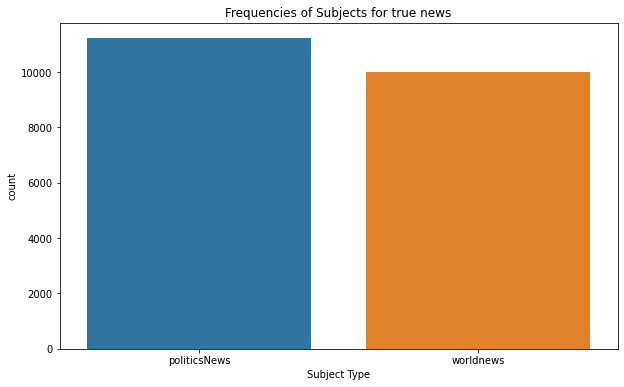

In [114]:
# count plot "Histogram" of Frequencies of Subjects for true news
plt.figure(figsize=(10,6))
plt.title("Frequencies of Subjects for true news")
sns.countplot(x = 'subject', data = true)
plt.xlabel('Subject Type')

In [115]:
true_text = ' '.join(true.text.tolist())
true_text

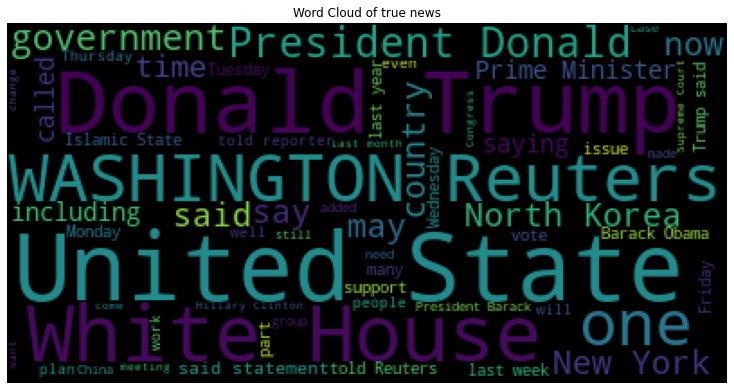

In [116]:
wordcloud_true = WordCloud().generate(true_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title("Word Cloud of true news")
plt.tight_layout(pad=0)
plt.show()

**Clean True and Preprocessing news dataset**

In [117]:
true.sample(5)

,title,text,subject,date
3402,Deutsche Bank ignores U.S. Trump/Russia query:...,FRANKFURT (Reuters) - Germany’s largest bank h...,politicsNews,"June 4, 2017"
7635,Trump mounts bid to turn Clinton controversy t...,PHOENIX (Reuters) - Sensing a potential turnin...,politicsNews,"October 30, 2016"
16888,"Three police officers killed, eight injured in...",CAIRO (Reuters) - Three police officers were k...,worldnews,"October 20, 2017"
9154,House panel to consider measure censuring IRS ...,WASHINGTON (Reuters) - A Republican-controlled...,politicsNews,"June 13, 2016"
12479,Bulgaria freezes assets of independent media p...,SOFIA (Reuters) - Bulgaria has frozen assets a...,worldnews,"December 12, 2017"


**Detect the news without publisher**

In [119]:
unknow_pubs = []
for i, row in enumerate(true.text.values):
  try:
    record = row.split('-', maxsplit = 1)
    record[1]
    assert(len(record[0]) < 120)
  except:
    unknow_pubs.append(i)

In [120]:
len(unknow_pubs)

221

In [121]:
true.iloc[unknow_pubs].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [123]:
pubs = []
temp_text = []
for index, row in enumerate(true.text.values):
  if index in unknow_pubs:
    temp_text.append(row)
    pubs.append('unk')
  else:
    record = row.split('-', maxsplit = 1)
    temp_text.append(record[1].strip())
    pubs.append(record[0].strip()) 

In [124]:
true['text'] = temp_text
true['publisher'] = pubs

In [125]:
true.sample(5)

,title,text,subject,date,publisher
1287,Republicans eye alternatives for getting to 20...,Republican lawmakers are considering indirect ...,politicsNews,"October 12, 2017",WASHINGTON (Reuters)
15842,UK parliament to consider Northern Ireland bud...,The British government expects to bring a budg...,worldnews,"November 2, 2017",LONDON (Reuters)
14255,"Yemen Houthis say Sanaa airport repaired, read...","Yemen s Sanaa airport, damaged in an air strik...",worldnews,"November 21, 2017",ADEN (Reuters)
12850,'This is not a life': migrants stranded on Gre...,Syrian migrant Bashar Wakaa and his heavily pr...,worldnews,"December 7, 2017","LESBOS, Greece (Reuters)"
7235,Chicago City Council passes mayor's 2017 budget,The Chicago City Council on Wednesday approved...,politicsNews,"November 16, 2016",CHICAGO (Reuters)


In [126]:
true_empty_text = [i for i, text in enumerate(true.text.tolist()) if str(text).strip() == '']

In [127]:
true_empty_text

[8924]

In [128]:
true.iloc[true_empty_text]

,title,text,subject,date,publisher
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",unk


In [129]:
true['text'] = true['title'] + " " + true['text'] 

In [130]:
true['text'] = true['text'].apply(lambda x : str(x).lower())

In [131]:
true['class'] = 1

In [132]:
true = true[['text', 'class']]

In [133]:
true.sample(5)

,text,class
14317,china supports cambodia's crackdown on politic...,1
20978,vietnam protests over chinese live-fire drills...,1
1335,pentagon says diplomatic tension with turkey n...,1
9744,white house 'deeply' concerned about china law...,1
3216,u.s. weighs sanctions on countries doing busin...,1


In [134]:
true[true.duplicated(keep= False)].sort_values(by=['text'])


,text,class
19277,china says to ban some petroleum exports to no...,1
1594,china says to ban some petroleum exports to no...,1
15307,china's xi says will persist with korean penin...,1
733,china's xi says will persist with korean penin...,1
11228,exclusive: atlantic city emergency fiscal mana...,1
11227,exclusive: atlantic city emergency fiscal mana...,1
8481,factbox: why the zika virus is causing alarm g...,1
8505,factbox: why the zika virus is causing alarm g...,1
11246,"for republican rubio, a moment of truth in rac...",1
11239,"for republican rubio, a moment of truth in rac...",1


In [136]:
print("Number of rows before remove duplicates : {}".format(true.shape[0]))

Number of rows before remove duplicates : 21211


In [138]:
print("Duplicated rows before remove them : ")
true[true.duplicated(keep= False)].sort_values(by=['text']).head(8)

Duplicated rows before remove them : 


,text,class
19277,china says to ban some petroleum exports to no...,1
1594,china says to ban some petroleum exports to no...,1
15307,china's xi says will persist with korean penin...,1
733,china's xi says will persist with korean penin...,1
11228,exclusive: atlantic city emergency fiscal mana...,1
11227,exclusive: atlantic city emergency fiscal mana...,1
8481,factbox: why the zika virus is causing alarm g...,1
8505,factbox: why the zika virus is causing alarm g...,1


In [139]:
print("Number of duplicates in data : {}".format(len(true[true.duplicated()]))) 

Number of duplicates in data : 15


In [140]:
#remove duplicated rows
true.drop_duplicates(inplace=True)

In [141]:
print("Number of duplicates in data after using drop_duplicates: {}".format(len(true[true.duplicated()]))) 

Number of duplicates in data after using drop_duplicates: 0


**EDA for fake news**

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [76]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [77]:
fake.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [142]:
print("Number of rows before remove duplicates : {}".format(fake.shape[0]))

Number of rows before remove duplicates : 23481


In [143]:
print("Duplicated rows before remove them : ")
fake[fake.duplicated(keep=False)].sort_values(by="text").head(8)

Duplicated rows before remove them : 


,title,text,subject,date
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


In [145]:
print("Number of duplicates in data : {}".format(len(fake[fake.duplicated()]))) 

Number of duplicates in data : 3


In [146]:
#remove duplicated rows
fake.drop_duplicates(inplace=True)

In [147]:
print("Number of duplicates in data after using drop_duplicates: {}".format(len(fake[fake.duplicated()]))) 

Number of duplicates in data after using drop_duplicates: 0


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

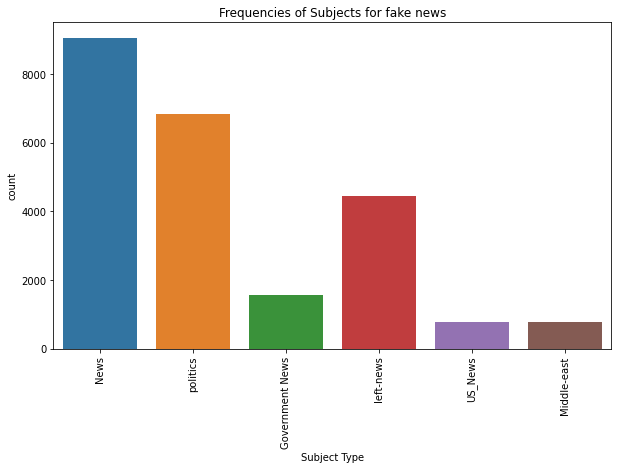

In [148]:
plt.figure(figsize=(10,6))
plt.title("Frequencies of Subjects for fake news")
sns.countplot(x = 'subject', data = fake)
plt.xlabel('Subject Type')
plt.xticks(rotation=90)

<function matplotlib.pyplot.show>

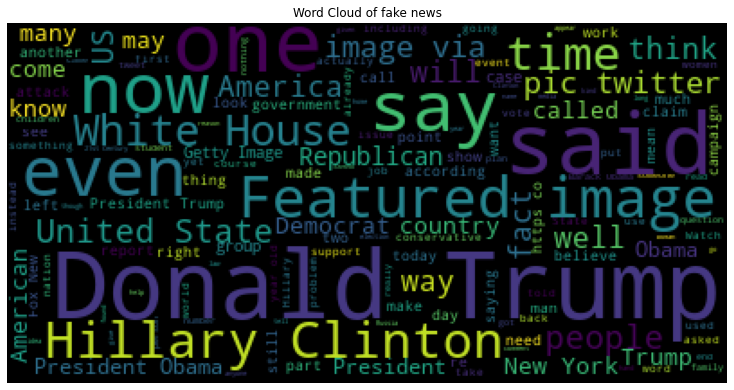

In [149]:
fake_text = ' '.join(fake.text.tolist())
wordcloud_fake =  WordCloud().generate(fake_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title("Word Cloud of fake news")
plt.tight_layout(pad=0)
plt.show

**Clean and Preprocessing Fake news dataset**

In [150]:
fake.sample(5)

,title,text,subject,date
10153,CAN YOU HEAR HIM NOW? President Trump Doubles ...,President Trump condemned hate groups today AG...,politics,"Aug 14, 2017"
17996,WATCH: DIAMOND AND SILK Make A Surprise Visit ...,They re President Trump s #1 fans and they ve ...,left-news,"Sep 9, 2017"
16191,ALARM TURNED OFF: Shocking Details on WHITE HO...,Secret Service personnel removed the alarm sen...,Government News,"Mar 21, 2017"
11861,FLASHBACK: Valerie Jarrett’s Daughter Hired By...,CNN Announced: The Justice Department and Sup...,politics,"Jan 19, 2017"
22307,Boiler Room #89 – Island of Misfit Toys,Tune in to the Alternate Current Radio Network...,US_News,"December 23, 2016"


In [151]:
fake_empty_text = [i for i, text in enumerate(fake.text.tolist()) if str(text).strip() == '']

In [ ]:
fake_empty_text

In [153]:
fake.iloc[fake_empty_text]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [154]:
fake['text'] = fake['title'] + " " + fake['text'] 

In [155]:
fake['text'] = fake['text'].apply(lambda x : str(x).lower())

In [156]:
fake['class'] = 0

In [157]:
fake = fake[['text', 'class']]

In [158]:
fake.sample(5)

,text,class
5716,hillary gives huge middle finger to gop bigot...,0
8563,dixie chicks’ natalie maines dusts off infamo...,0
20622,9 facts about slavery democrats don’t want you...,0
20870,watch insane videos…chicago cop spills the bea...,0
4048,"trump freaks out, talks ‘world war three’ (vi...",0


In [159]:
print("Number of rows before remove duplicates : {}".format(fake.shape[0]))

Number of rows before remove duplicates : 23478


In [160]:
print("Duplicated rows before remove them : ")
fake[fake.duplicated(keep=False)].sort_values(by="text").head(8)

Duplicated rows before remove them : 


,text,class
20771,#anyonebuthillary: new poll shows bernie suppo...,0
14160,#anyonebuthillary: new poll shows bernie suppo...,0
17930,#austin: fights break out between police and s...,0
9841,#austin: fights break out between police and s...,0
19211,#berkeley crazy! rioters chase and beat people...,0
11756,#berkeley crazy! rioters chase and beat people...,0
11755,#berkeley irony alert! anarchists loot starbuc...,0
19210,#berkeley irony alert! anarchists loot starbuc...,0


In [161]:
print("Number of duplicates in data : {}".format(len(fake[fake.duplicated()]))) 

Number of duplicates in data : 5570


In [162]:
#remove duplicated rows
fake.drop_duplicates(inplace=True)

In [163]:
print("Number of duplicates in data after using drop_duplicates: {}".format(len(fake[fake.duplicated()]))) 

Number of duplicates in data after using drop_duplicates: 0


**All Dataset**

In [164]:
dataset = true.append(fake, ignore_index=True)

In [165]:
dataset.sample(5)

,text,class
38306,first grade teacher reads transgender book to ...,0
9709,u.s. lawmakers debate funding gimmick in defen...,1
19610,"tillerson, russia's lavrov to meet on sunday: ...",1
27845,carly fiorina: ted cruz’s chances of winning ...,0
28988,meet the incredibly racist gop senator that j...,0


In [166]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 10.4 MB 4.6 MB/s 
     |████████████████████████████████| 2.2 MB 34.9 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-jmdd861r
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip

In [167]:
import preprocess_kgptalkie as ps

In [168]:
# clean data and remove speci
dataset['text'] = dataset['text'].apply(lambda x : ps.remove_special_chars(x))

In [169]:
# take text and preprocess 'remove stopwords [a, the, and, thus, ... etc] and punctations[,%$ ..etc] and len of text less than 3' 
def clean_text(text):
    """
        text: a string 
        return: cleaned string
    """
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and token not in punctation and  len(token) >= 3 :
            token = token.lower() 
            result.append(token)    
    return " ".join(result)

In [170]:
dataset['text'] = dataset['text'].map(clean_text)
dataset.head()

,text,class
0,budget fight looms republicans flip fiscal scr...,1
1,military accept transgender recruits monday pe...,1
2,senior republican senator let mueller job spec...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump wants postal service charge amazon shipm...,1


**Vectorization 'Word2Vector'**

In [171]:
X = [t.split() for t in dataset.text.tolist()]

In [172]:
y = dataset['class'].values

In [173]:
print(X[0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'way', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'big', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'nondefense', 'discretionary', 'spending', 'programs', 'suppo

In [174]:
Dim = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=Dim, window=10, min_count=1)


In [175]:
w2v_model.wv['egypt']

array([-1.1916304e+00, -3.0227366e-01, -1.4515913e+00,  1.7536169e+00,
       -1.5517637e+00,  3.4721750e-01,  6.6248572e-01,  1.6411624e+00,
       -8.7402456e-02, -6.0450482e-01, -1.7555960e-01, -1.6060834e+00,
        9.8246044e-01, -2.8042679e+00,  3.6397785e-01,  2.7361456e-01,
        2.0588374e+00, -9.3742251e-01, -1.9481902e+00, -7.4129122e-01,
        1.6992738e+00,  1.7743609e+00,  1.3938837e+00, -3.3657126e+00,
       -9.3336028e-01, -1.9969678e+00, -2.2281139e+00, -2.6697834e+00,
        1.5777607e+00, -3.0289222e-02,  3.3402261e-01, -3.0919618e-03,
        7.5262326e-01, -7.8612500e-01, -1.0377108e+00, -1.1441387e+00,
       -2.9255078e+00,  1.2657229e+00, -1.8276244e+00, -2.1474108e-01,
       -4.8849255e-01, -4.7250047e-01, -7.4313784e-01, -1.7172688e+00,
        5.8182579e-01, -1.7718141e+00,  1.2134136e+00, -6.8028516e-01,
       -5.7706958e-01, -1.4031073e-01,  3.9452958e+00,  1.4406539e+00,
        3.8076794e-01, -1.8551303e+00, -1.5151026e+00,  1.7296933e+00,
      

In [176]:
w2v_model.similar_by_word('egypt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('egyptian', 0.7754193544387817),
 ('cairo', 0.7679709196090698),
 ('kuwait', 0.7395327687263489),
 ('bahrain', 0.730968177318573),
 ('uae', 0.715132474899292),
 ('egypts', 0.6827346086502075),
 ('tunisia', 0.6700365543365479),
 ('jordanian', 0.6676992177963257),
 ('qatar', 0.6674880981445312),
 ('alsisi', 0.6622712016105652)]

In [177]:
toknizer = Tokenizer()
toknizer.fit_on_texts(X)
X = toknizer.texts_to_sequences(X)

In [178]:
toknizer.word_index

{'said': 1,
 'trump': 2,
 'president': 3,
 'people': 4,
 'state': 5,
 'new': 6,
 'house': 7,
 'donald': 8,
 'states': 9,
 'government': 10,
 'republican': 11,
 'clinton': 12,
 'obama': 13,
 'united': 14,
 'told': 15,
 'white': 16,
 'campaign': 17,
 'like': 18,
 'election': 19,
 'party': 20,
 'time': 21,
 'news': 22,
 'year': 23,
 'country': 24,
 'years': 25,
 'security': 26,
 'trumps': 27,
 'republicans': 28,
 'hillary': 29,
 'court': 30,
 'national': 31,
 'percent': 32,
 'video': 33,
 'law': 34,
 'political': 35,
 'presidential': 36,
 'north': 37,
 'going': 38,
 'senate': 39,
 'police': 40,
 'media': 41,
 'russia': 42,
 'vote': 43,
 'democratic': 44,
 'support': 45,
 'says': 46,
 'american': 47,
 'administration': 48,
 'week': 49,
 'officials': 50,
 'including': 51,
 'foreign': 52,
 'group': 53,
 'think': 54,
 'know': 55,
 'office': 56,
 'military': 57,
 'statement': 58,
 'according': 59,
 'tax': 60,
 'way': 61,
 'federal': 62,
 'called': 63,
 'million': 64,
 'saying': 65,
 'america':

**Hist of words length**

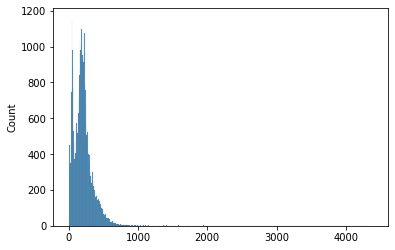

In [179]:
sns.histplot([len(x) for x in X ], bins = 700)

In [180]:
noc = np.array([len(x) for x in X ])
len(noc[noc > 1000])

131

In [181]:
max_len = 1000
X = pad_sequences(X, maxlen=max_len)

In [194]:
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [183]:
vocab = toknizer.word_index
vocab_size = len(toknizer.word_index)+1

In [184]:
vocab_size

198984

In [185]:
def get_weight_matrix():
  weight_matrix = np.zeros((vocab_size, Dim))
  for word, i in vocab.items():
    weight_matrix[i] = w2v_model.wv[word] 
  return weight_matrix

In [186]:
embeddings_vec = get_weight_matrix()

In [187]:
embeddings_vec.shape

(198984, 100)

In [188]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=Dim, weights = [embeddings_vec], input_length= max_len, trainable = False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [189]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         19898400  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 20,015,777
Trainable params: 117,377
Non-trainable params: 19,898,400
_________________________________________________________________


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [191]:
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
642/642 [==============================] - 110s 161ms/step - loss: 0.1506 - accuracy: 0.9441 - val_loss: 0.1209 - val_accuracy: 0.9562
Epoch 2/10
642/642 [==============================] - 103s 160ms/step - loss: 0.0767 - accuracy: 0.9725 - val_loss: 0.0584 - val_accuracy: 0.9801
Epoch 3/10
642/642 [==============================] - 103s 160ms/step - loss: 0.0494 - accuracy: 0.9832 - val_loss: 0.0633 - val_accuracy: 0.9753
Epoch 4/10
642/642 [==============================] - 103s 160ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0321 - val_accuracy: 0.9897
Epoch 5/10
642/642 [==============================] - 103s 161ms/step - loss: 0.0259 - accuracy: 0.9907 - val_loss: 0.0356 - val_accuracy: 0.9874
Epoch 6/10
642/642 [==============================] - 103s 161ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.0455 - val_accuracy: 0.9845
Epoch 7/10
642/642 [==============================] - 103s 160ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0336 -

In [192]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

In [195]:
accuracy_score(y_test, y_pred)

0.9888502454991817

In [196]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4442
           1       0.98      1.00      0.99      5334

    accuracy                           0.99      9776
   macro avg       0.99      0.99      0.99      9776
weighted avg       0.99      0.99      0.99      9776



In [197]:
def process_input(input):
  input = toknizer.texts_to_sequences(input)
  input = pad_sequences(input, maxlen=max_len)
  return input

In [205]:
fake_one= ["Defence minister reminds Israel on Twitter that ‘Pakistan is a nuclear state too’ after fake story says Israel had threatened to destroy Pakistan"]
(model.predict(process_input(fake_one)) > 0.5).astype(int)

array([[0]])

In [199]:
true_one = ["The BBC reported that Sammie-Jo Forde, 32, died in the Ulster hospital on Saturday, where she had been treated on the same ward as her mother, Heather Maddern, 55, who died on 31 August."]
(model.predict(process_input(true_one)) > 0.5).astype(int)

array([[1]])